# XY - Regression - Group 11

In [1]:
import os
import csv
import cv2
import glob
import subprocess
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Video
from datetime import datetime as dt

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class LaneDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        # Standard JetBot transforms + Color Augmentation
        self.transform = transform if transform else transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            # Normalize using ImageNet stats (standard for ResNet)
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0] # Filename
        img_path = os.path.join(self.root_dir, img_id)
        
        # Check if file exists in folder
        if not os.path.exists(img_path):
            return self.__getitem__((index + 1) % len(self.annotations))
        
        image = Image.open(img_path).convert("RGB")
        
        # Get the X, Y coordinates
        label = torch.tensor(
            self.annotations.iloc[index, 1:3].values.astype('float32')
        ) # Columns 1 and 2 are x_norm, y_norm

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Hyperparameters
batch_size = 16

#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\all"
#csv_file = "labels.csv"

data_dir = "./dataset/all_original"
csv_file = "./dataset/labels_original.csv"

# Ratio: 80% train, 10% test, 10% validation
train_dir = "./dataset/train_original" # Training Dataset
test_dir = "./dataset/test_original"   # Testing Dataset
val_dir = "./dataset/val_original"     # Validation Dataset

In [5]:
full_dataset = LaneDataset(csv_file=csv_file, root_dir=data_dir)

train_dataset = LaneDataset(csv_file = csv_file, root_dir = train_dir)
test_dataset = LaneDataset(csv_file = csv_file, root_dir = test_dir)
val_dataset = LaneDataset(csv_file = csv_file, root_dir = val_dir)

In [6]:
# Split into Train (80%) and Validation (20%)
#train_size = int(0.8 * len(full_dataset))
#test_size = len(full_dataset) - train_size
#train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
#test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)  # check if shuffle needs to be done here too

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True) # drop last avoids error
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

In [7]:
class EleveNet(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(EleveNet, self).__init__()
        
        # Input dimensions: (batch_size, 3, 224, 224)
        
        # Convolutional layers with batch norm
        self.conv1 = nn.Conv2d(3, 28, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(28)
        self.conv2 = nn.Conv2d(28, 56, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(56)
        self.conv3 = nn.Conv2d(56, 112, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(112)
        #self.conv4 = nn.Conv2d(112, 224, kernel_size=3, padding=1)
        #self.bn4 = nn.BatchNorm2d(224)

        self.pooling = nn.MaxPool2d(2, 2)  # Standard pooling
        
        # for flexible input image resolutions use adaptive pooling:
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()
        self.flatten = nn.Flatten()
        
        #self.linear1 = nn.Linear(224 * 14 * 14, 15)  # 224 * 14 * 14 # prev 192
        self.linear1 = nn.Linear(112 * 28 * 28, 15)  # 224 * 14 * 14 # prev 192
        self.bn7 = nn.BatchNorm1d(15) # prev 192

        self.dropout = nn.Dropout(p=dropout_prob)
        self.output = nn.Linear(15, 2) # prev 15

    def forward(self, x):
        # Input x dimensions: (batch_size, 3, 224, 224)
        
        # Conv block 1
        x = self.conv1(x)  # (batch_size, 28, 224, 224)
        x = self.bn1(x)
        x = self.pooling(x)  # (batch_size, 28, 112, 112)
        #x = self.silu(x)     # x = self.relu()
        #x = self.relu(x)
        x = self.leaky_relu(x)
        
        # Conv block 2
        x = self.conv2(x)  # (batch_size, 56, 112, 112)
        x = self.bn2(x)
        x = self.pooling(x)  # (batch_size, 56, 56, 56)
        #x = self.silu(x)
        #x = self.relu(x)
        x = self.leaky_relu(x)
        
        # Conv block 3
        x = self.conv3(x)  # (batch_size, 112, 56, 56)
        x = self.bn3(x)
        x = self.pooling(x)  # (batch_size, 112, 28, 28)
        #x = self.silu(x)
        #x = self.relu(x)
        x = self.leaky_relu(x)
        
        # Conv block 4
        #x = self.conv4(x)  # (batch_size, 224, 28, 28)
        #x = self.bn4(x)
        #x = self.pooling(x)  # (batch_size, 224, 14, 14)
        #x = self.silu(x)
        #x = self.relu(x)
        #x = self.leaky_relu(x)

        # Flatten
        # After 4 pooling layers: (batch_size, 224, 14, 14)
        x = self.flatten(x)  # (batch_size, 224 * 14 * 14) = (batch_size, 43904)

        # Adaptive pooling for flexible image size
        #x = self.adaptive_pool(x)  # (batch_size, 1024, 3, 3)
        
        x = self.linear1(x)  # (batch_size, 192)
        x = self.bn7(x)
        #x = self.silu(x)
        #x = self.relu(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.output(x)  # (batch_size, num_classes)

        return x

In [8]:
model = EleveNet(dropout_prob=0.3).to(device)  # For 30% dropout

In [9]:
summary(model, input_size = (3, 224, 224))    # if using torchsummary # change back to 128 128

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 28, 224, 224]             784
       BatchNorm2d-2         [-1, 28, 224, 224]              56
         MaxPool2d-3         [-1, 28, 112, 112]               0
         LeakyReLU-4         [-1, 28, 112, 112]               0
            Conv2d-5         [-1, 56, 112, 112]          14,168
       BatchNorm2d-6         [-1, 56, 112, 112]             112
         MaxPool2d-7           [-1, 56, 56, 56]               0
         LeakyReLU-8           [-1, 56, 56, 56]               0
            Conv2d-9          [-1, 112, 56, 56]          56,560
      BatchNorm2d-10          [-1, 112, 56, 56]             224
        MaxPool2d-11          [-1, 112, 28, 28]               0
        LeakyReLU-12          [-1, 112, 28, 28]               0
          Flatten-13                [-1, 87808]               0
           Linear-14                   

In [22]:
# Hyperparameters
lr = 1e-4
epochs = 40

# Training Setup
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

print(f"Training on {device} with {len(train_dataset)} images...")

Training on cuda with 3797 images...


In [23]:
train_losses = []
val_losses = []
train_maes = [] # mean absolut error (between prediction and label)
val_maes = []

# calculate metric for regression (accuracy)
def calculate_mae(outputs, labels):
    return torch.abs(outputs - labels).mean().item() # how far is the prediction off to the actual labels (groudn truth)

In [24]:
current_dt = dt.now()
dt_stamp = f"{current_dt.year}{current_dt.month:02d}{current_dt.day:02d}{current_dt.hour:02d}{current_dt.minute:02d}{current_dt.second:02d}" 
print(dt_stamp)

20260201204947


In [26]:
best_val_loss = float('inf')

# training loop
for epoch in range(epochs):
    # training
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    
    # loading bar for showing progress
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", unit="batch", leave=False)
    
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        current_mae = calculate_mae(outputs, labels)
        running_mae += current_mae
        
        # Update the progress bar with the current batch loss
        train_bar.set_postfix(loss=f"{loss.item():.4f}", mae=f"{current_mae:.4f}")
    
    avg_train_loss = running_loss / len(train_loader)
    avg_train_mae = running_mae / len(train_loader)
    train_losses.append(avg_train_loss)
    train_maes.append(avg_train_mae)
    
    # validation
    model.eval()
    running_val_loss = 0.0
    running_val_mae = 0.0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", unit="batch", leave=False)
    
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            v_loss = loss_fn(outputs, labels).item()
            v_mae = calculate_mae(outputs, labels)
            
            running_val_loss += v_loss
            running_val_mae += v_mae
            
            val_bar.set_postfix(val_loss=f"{v_loss:.4f}", val_mae=f"{v_mae:.4f}")
            
    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_mae = running_val_mae / len(val_loader)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)
    
    # print losses etc
    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MAE: {avg_val_mae:.4f}")
    
    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"./models/best_steering_model_xy_EleveNet2_{dt_stamp}.pth")
        print("Saved Best Model (Validation Loss Improved)\n")

    epoch_log = epoch + 1
    # Log losses and error for plotting even if variables are lost
    file_path = f"elevenet2_loss_and_error_{dt_stamp}.csv"
    f = open(file_path, "a", newline='', encoding='utf-8')
    writer = csv.writer(f)
    
    # Write the header row, only once
    if epoch_log == 1:
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train MAE", "Val MAE"])

    writer.writerow([epoch_log,avg_train_loss,avg_val_loss,avg_train_mae,avg_val_mae])
    f.close()

print("\n Training Done")

Epoch 1/40: Train Loss: 0.0385 | Val Loss: 0.0090 | Val MAE: 0.0764
Saved Best Model (Validation Loss Improved)



Epoch 2/40: Train Loss: 0.0335 | Val Loss: 0.0070 | Val MAE: 0.0648
Saved Best Model (Validation Loss Improved)



Epoch 3/40: Train Loss: 0.0319 | Val Loss: 0.0073 | Val MAE: 0.0671


Epoch 4/40: Train Loss: 0.0282 | Val Loss: 0.0056 | Val MAE: 0.0586
Saved Best Model (Validation Loss Improved)



Epoch 5/40: Train Loss: 0.0252 | Val Loss: 0.0065 | Val MAE: 0.0636


Epoch 6/40: Train Loss: 0.0234 | Val Loss: 0.0057 | Val MAE: 0.0598


Epoch 7/40: Train Loss: 0.0229 | Val Loss: 0.0069 | Val MAE: 0.0662


Epoch 8/40: Train Loss: 0.0216 | Val Loss: 0.0044 | Val MAE: 0.0502
Saved Best Model (Validation Loss Improved)



Epoch 9/40: Train Loss: 0.0198 | Val Loss: 0.0051 | Val MAE: 0.0567


Epoch 10/40: Train Loss: 0.0183 | Val Loss: 0.0033 | Val MAE: 0.0426
Saved Best Model (Validation Loss Improved)



Epoch 11/40: Train Loss: 0.0178 | Val Loss: 0.0048 | Val MAE: 0.0533


Epoch 12/40: Train Loss: 0.0163 | Val Loss: 0.0045 | Val MAE: 0.0546


Epoch 13/40: Train Loss: 0.0161 | Val Loss: 0.0029 | Val MAE: 0.0400
Saved Best Model (Validation Loss Improved)



Epoch 14/40: Train Loss: 0.0148 | Val Loss: 0.0029 | Val MAE: 0.0417


Epoch 15/40: Train Loss: 0.0139 | Val Loss: 0.0035 | Val MAE: 0.0455


Epoch 16/40: Train Loss: 0.0141 | Val Loss: 0.0026 | Val MAE: 0.0385
Saved Best Model (Validation Loss Improved)



Epoch 17/40: Train Loss: 0.0127 | Val Loss: 0.0032 | Val MAE: 0.0433


Epoch 18/40: Train Loss: 0.0123 | Val Loss: 0.0035 | Val MAE: 0.0469


Epoch 19/40: Train Loss: 0.0115 | Val Loss: 0.0028 | Val MAE: 0.0414


Epoch 20/40: Train Loss: 0.0111 | Val Loss: 0.0034 | Val MAE: 0.0437


Epoch 21/40: Train Loss: 0.0103 | Val Loss: 0.0023 | Val MAE: 0.0359
Saved Best Model (Validation Loss Improved)



Epoch 22/40: Train Loss: 0.0100 | Val Loss: 0.0032 | Val MAE: 0.0437


Epoch 23/40: Train Loss: 0.0097 | Val Loss: 0.0024 | Val MAE: 0.0367


Epoch 24/40: Train Loss: 0.0090 | Val Loss: 0.0019 | Val MAE: 0.0322
Saved Best Model (Validation Loss Improved)



Epoch 25/40: Train Loss: 0.0090 | Val Loss: 0.0023 | Val MAE: 0.0370


Epoch 26/40: Train Loss: 0.0084 | Val Loss: 0.0031 | Val MAE: 0.0438


Epoch 27/40: Train Loss: 0.0087 | Val Loss: 0.0016 | Val MAE: 0.0294
Saved Best Model (Validation Loss Improved)



Epoch 28/40: Train Loss: 0.0082 | Val Loss: 0.0019 | Val MAE: 0.0320


Epoch 29/40: Train Loss: 0.0076 | Val Loss: 0.0018 | Val MAE: 0.0321


Epoch 30/40: Train Loss: 0.0074 | Val Loss: 0.0024 | Val MAE: 0.0374


Epoch 31/40: Train Loss: 0.0073 | Val Loss: 0.0015 | Val MAE: 0.0286
Saved Best Model (Validation Loss Improved)



Epoch 32/40: Train Loss: 0.0070 | Val Loss: 0.0021 | Val MAE: 0.0365


Epoch 33/40: Train Loss: 0.0070 | Val Loss: 0.0020 | Val MAE: 0.0329


Epoch 34/40: Train Loss: 0.0064 | Val Loss: 0.0017 | Val MAE: 0.0310


Epoch 35/40: Train Loss: 0.0062 | Val Loss: 0.0018 | Val MAE: 0.0306


Epoch 36/40: Train Loss: 0.0062 | Val Loss: 0.0020 | Val MAE: 0.0346


Epoch 37/40: Train Loss: 0.0062 | Val Loss: 0.0016 | Val MAE: 0.0300


Epoch 38/40: Train Loss: 0.0060 | Val Loss: 0.0015 | Val MAE: 0.0274


Epoch 39/40: Train Loss: 0.0057 | Val Loss: 0.0018 | Val MAE: 0.0322


Epoch 40/40: Train Loss: 0.0055 | Val Loss: 0.0010 | Val MAE: 0.0225
Saved Best Model (Validation Loss Improved)


 Training Done


In [27]:
print("Evaluating on Test Set")

model.load_state_dict(torch.load(f"./models/best_steering_model_xy_EleveNet2_{dt_stamp}.pth")) # Load best version
model.eval()

final_test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = loss_fn(outputs, labels)
        final_test_loss += loss.item()

avg_test_loss = final_test_loss / len(test_loader)
print(f"Final Test Loss: {avg_test_loss:.4f}")

C:\Users\agah2\AppData\Local\Temp\ipykernel_5468\1049721648.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./models/best_steering_mod

Evaluating on Test Set
Final Test Loss: 0.0010


## Open the latest file with Loss and Error values and plot

In [28]:
# Find all CSV files with correct naming convention
file_pattern = "elevenet_loss_and_error_*.csv"
matching_files = glob.glob(file_pattern)

if not matching_files:
    print("No CSV file found.")
else:
    # Parse date from filename
    def parse_date(filename):
        dt_str = filename.split('_')[-1].split('.')[0]
        return dt.strptime(dt_str, "%Y%m%d%H%M%S")

    latest_file = max(matching_files, key=lambda x: parse_date(x))
    print(f"Found latest file: {latest_file}")

Found latest file: elevenet_loss_and_error_20260128140030.csv


In [29]:
# Read file
with open(latest_file, 'r', newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        rows = list(reader)

In [30]:
# Extract data
epochs = []
train_losses = []
val_losses = []
train_maes = []
val_maes = []

for row in rows:
    epochs.append(int(row["Epoch"]))
    train_losses.append(float(row["Train Loss"]))
    val_losses.append(float(row["Val Loss"]))
    train_maes.append(float(row["Train MAE"]))
    val_maes.append(float(row["Val MAE"]))

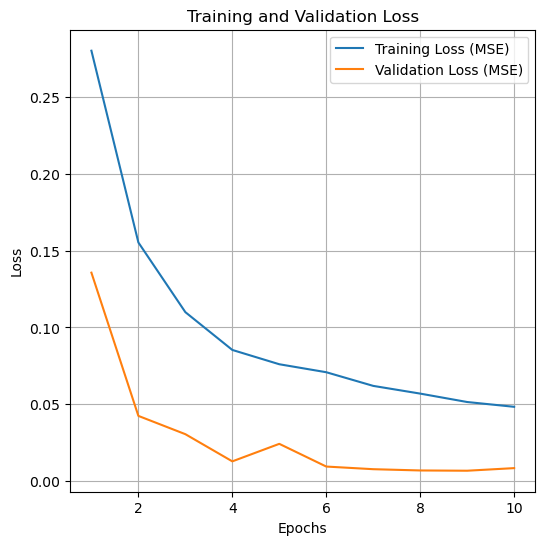

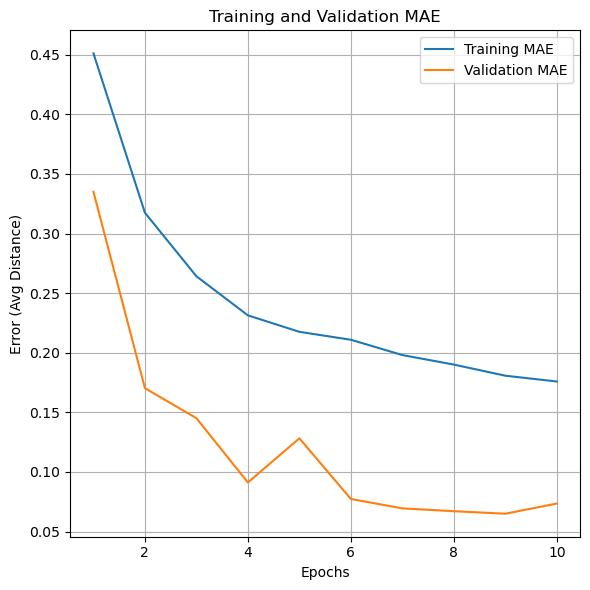

In [31]:
# Plot data
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_losses, label='Training Loss (MSE)')
plt.plot(epochs, val_losses, label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
#plt.savefig('./ReportImages/elevenet_loss.jpg', bbox_inches='tight', dpi=300)

plt.figure(figsize=(6, 6))
plt.plot(epochs, train_maes, label='Training MAE')
plt.plot(epochs, val_maes, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Error (Avg Distance)')
plt.grid()
plt.legend()
#plt.savefig('./ReportImages/elevenet_mae.jpg', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

# Load and test model

In [ ]:
#image_path = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\big_corr_1_0013.jpg" # one fixed image

image_path = "./dataset/test_original/frame_000142.png"

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # ImageNet mean and std
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
model.load_state_dict(torch.load('./models/best_steering_model_xy_EleveNet.pth'))
model.eval()
print("Done")

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    
    #print(image.shape)
    
    model.eval()  # Disables BatchNorm's training behavior
    
    with torch.no_grad():
        image = image.to(device)  # Fixed: assign back to image
        output = model(image)
    
    return output  # Return just the string label instead of array

In [ ]:
output = predict_image(image_path)

In [ ]:
pred_coord = output.cpu().numpy()
print(pred_coord)

In [ ]:
coordinates = pred_coord[0]

xpred = coordinates[0]
ypred = coordinates[1]

print(f"x = {xpred}, y = {ypred}")

In [ ]:
image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)

In [ ]:
# Prediction (Green Circle)
pred_x_norm = xpred
pred_y_norm = ypred
pred_x = int(np.clip(pred_x_norm * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y = int(np.clip(pred_y_norm * image_cv.shape[0], 0, image_cv.shape[0] - 1))

print(f"x: {pred_x}")
print(f"y: {pred_y}")

In [ ]:
plt.figure(figsize=(12,6))

plt.title("Input Image")
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x, pred_y, 'go')
plt.axis("off")

plt.show()
#plt.savefig("EleveNet_original_14122025")

# Test with random images

In [ ]:
#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\val"

data_dir = "./dataset/all_original"

In [ ]:
directory = Path(data_dir)
images = [file for file in directory.iterdir()]

random_image = rn.choice(images)
print(f"Random image: {random_image.name}")

image_path = random_image

model.load_state_dict(torch.load('./models/best_steering_model_xy_EleveNet.pth'))
model.eval()
print("Done")

output = predict_image(image_path)

pred_coord = output.cpu().numpy()
print(pred_coord)
coordinates = pred_coord[0]

xpred = coordinates[0]
ypred = coordinates[1]
print(f"x = {xpred}, y = {ypred}")

image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)


# Prediction (Green Circle)
pred_x_norm = xpred
pred_y_norm = ypred
pred_x = int(np.clip(pred_x_norm * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y = int(np.clip(pred_y_norm * image_cv.shape[0], 0, image_cv.shape[0] - 1))

plt.figure(figsize=(12,6))
plt.title("Input Image")
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x, pred_y, 'bo')
plt.axis("off")
plt.show()

## Plot inner layer outputs

In [ ]:
# Dict to store layer outputs
activations = {}

# Hook function to store outputs
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()  # Detach to avoid gradients
    return hook

In [ ]:
image_path = "./dataset/all_original/frame_000105.png"

In [ ]:
image = Image.open(image_path).convert('RGB')
image = transform(image).to(device)
image = image.unsqueeze(0)

In [ ]:
# Register hooks for specific layers
hook1 = model.conv1.register_forward_hook(get_activation('conv1'))
hook2 = model.conv2.register_forward_hook(get_activation('conv2'))
hook3 = model.conv3.register_forward_hook(get_activation('conv3'))
#hook4 = model.conv4.register_forward_hook(get_activation('conv4'))
#hook5 = model.conv5.register_forward_hook(get_activation('conv5'))
#hook6 = model.conv6.register_forward_hook(get_activation('conv6'))

# Forward pass with a dummy input (or your actual image)
inputs = image   #torch.randn(1, 3, 128, 128)  # (batch, channels, height, width)
output = model(inputs)

# Remove hooks (important to avoid memory leaks)
hook1.remove()
hook2.remove()
hook3.remove()
#hook4.remove()
#hook5.remove()
#hook6.remove()

In [ ]:
# Visualize feature maps
def visualize_activations(layer_name, num_filters=16):
    act = activations[layer_name].squeeze(0)  # Remove batch dim
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 2))
    for i in range(num_filters):
        axes[i].imshow(act[i].cpu(), cmap='gray')  # Show i-th filter's output
        axes[i].axis('off')
    plt.suptitle(f'Activations: {layer_name}', y=1.1)
    plt.show()

# Visualize first 16 filters of conv1 and conv4
visualize_activations('conv1', num_filters=16)
visualize_activations('conv2', num_filters=16)
visualize_activations('conv3', num_filters=16)
#visualize_activations('conv4', num_filters=16)
#visualize_activations('conv5', num_filters=16)
#visualize_activations('conv6', num_filters=16)

# Make multiple predictions and measure average

In [ ]:
device = torch.device("cuda")
model.to(device).eval()

# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up: 10-20 runs to initialize kernels and memory
print("Warming up")
for _ in range(20):
    _ = model(dummy_input)

# Setup for multiple runs
repetitions = 100
timings = np.zeros((repetitions, 1)) # Array to store results
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

print(f"Starting {repetitions} iterations")

# Measurement Loop
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        
        # WAIT for GPU to finish the work of this specific iteration
        torch.cuda.synchronize()
        
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

# Statistics
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

print(f"\n Statistics")
print(f"Average Inference Time: {mean_syn:.3f} ms")
print(f"Standard Deviation:     {std_syn:.3f} ms")
print(f"Throughput:             {1000/mean_syn:.2f} FPS")

# Predict point in Video

In [ ]:
# Configuration
model_path = './models/best_steering_model_xy_EleveNet.pth'

#video_path = 'big_corr_w_obs_a_video.mp4'
# u_corr.mp4
video_path = './BIP_videos_roboter_cam/big_corr_w_sun_2.mp4'

#os.chdir('..')
output_video_path = './inference_videos/output_video_EleveNet_LeakyReLU.mp4' # Where the annotated video will be saved

In [ ]:
# Defining Image Preprocessing Transforms
# NOTE: These MUST match the inference transforms from training/testing!
inference_transforms = transforms.Compose([
    # Resize the image to 224x224 (standard input size for ResNet)
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    # Normalize using ImageNet stats (standard for ResNet)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Video Processing Loop
def process_video(model, video_path, output_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    # Get video properties for saving the output
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define output video writer
    fourcc = cv2.VideoWriter_fourcc(*'avc1') 
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_count = 0
    print(f"Processing video with {fps} FPS")

    while cap.isOpened():
        ret, frame_cv = cap.read() # Read a frame

        if not ret:
            # End of video stream
            break
        
        frame_count += 1
        
        # Preprocessing (CV2 -> PyTorch Tensor)
        # Convert OpenCV BGR image to PIL RGB image
        frame_rgb = cv2.cvtColor(frame_cv, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)

        # Apply transforms
        image_tensor = inference_transforms(frame_pil).unsqueeze(0).to(device) # Add batch dimension (1, 3, H, W)

        # Inference
        with torch.no_grad():
            prediction = model(image_tensor).cpu().numpy()[0]
        
        # Denormalization and Visualization
        # Denormalize coordinates (from 0.0-1.0 to pixel values)
        pred_x_norm, pred_y_norm = prediction
        
        # Clamp coordinates to ensure they are within image bounds
        pred_x = int(np.clip(pred_x_norm * width, 0, width - 1))
        pred_y = int(np.clip(pred_y_norm * height, 0, height - 1))

        # Plot Prediction (Green Circle)
        cv2.circle(frame_cv, (pred_x, pred_y), 8, (0, 255, 0), -1) 
        
        # Draw Steering Vector (Blue Line)
        # From bottom center to the predicted point
        bottom_center = (width // 2, height)
        cv2.line(frame_cv, bottom_center, (pred_x, pred_y), (255, 0, 0), 2)
        
        # Add Info Text
        cv2.putText(frame_cv, f'Target: ({pred_x:.0f}, {pred_y:.0f})', 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Display and Save
        out.write(frame_cv)         # Write the annotated frame to the output video
        cv2.imshow('Video Prediction', frame_cv) # Display the frame
        
        # Wait a small amount of time (1 ms) to allow the window to refresh
        # Press 'q' to quit early
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Cleanup
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processing finished. Annotated video saved to: {output_path}")

In [ ]:
try:
    process_video(model, video_path, output_video_path)
except Exception as e:
    print(f"An error occured: {e}")

In [ ]:
Video("./inference_videos/output_video_EleveNet_ReLU.mp4")

In [ ]:
Video("./inference_videos/output_video_EleveNet_LeakyReLU.mp4")

In [ ]:
# Export to ONNX
model.to('cpu')

dummy_input = torch.randn(1, 3, 224, 224)
dummy_input.to('cpu')

torch.onnx.export(model, dummy_input, "model.onnx")

# Open in Python
import netron
netron.start("model.onnx")